# Imports

In [55]:
import numpy as np
import pandas as pd

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')


# Data Loading

In [ ]:
df = pd.read_csv('../datasets/assignment_01_data.csv')
df.info() # check for any missing values
df.head() # checking datatypes (continuous/categorical/etc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   X3      1000 non-null   float64
 3   X4      1000 non-null   float64
 4   X5      1000 non-null   float64
 5   X6      1000 non-null   float64
 6   X7      1000 non-null   float64
 7   X8      1000 non-null   float64
 8   Y       1000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 70.4+ KB


,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,-0.604285,-0.610629,0.026014,0.019710,0.406532,0.678796,0.524360,0.404739,B
1,-0.111772,-1.125178,0.744157,0.078315,0.088176,0.891009,0.018460,0.536511,B
2,-0.916802,1.965494,0.150022,0.388770,0.179276,0.064449,0.159279,0.951204,B
3,-0.280479,0.920669,0.208949,0.940153,0.854437,0.688172,0.365126,0.985259,A
4,1.856025,1.043214,0.167088,0.207002,0.979049,0.641019,0.628764,0.045912,B


# Data Preprocessing

In [18]:
Y = df["Y"]
features = df[[c for c in df.columns if c != "Y"]]

X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=3619)


# Visualization & EDA

## Seaborn Pairplot
Honestly, this is such an eyesore I didn't really end up gleaning much insight from this graphic

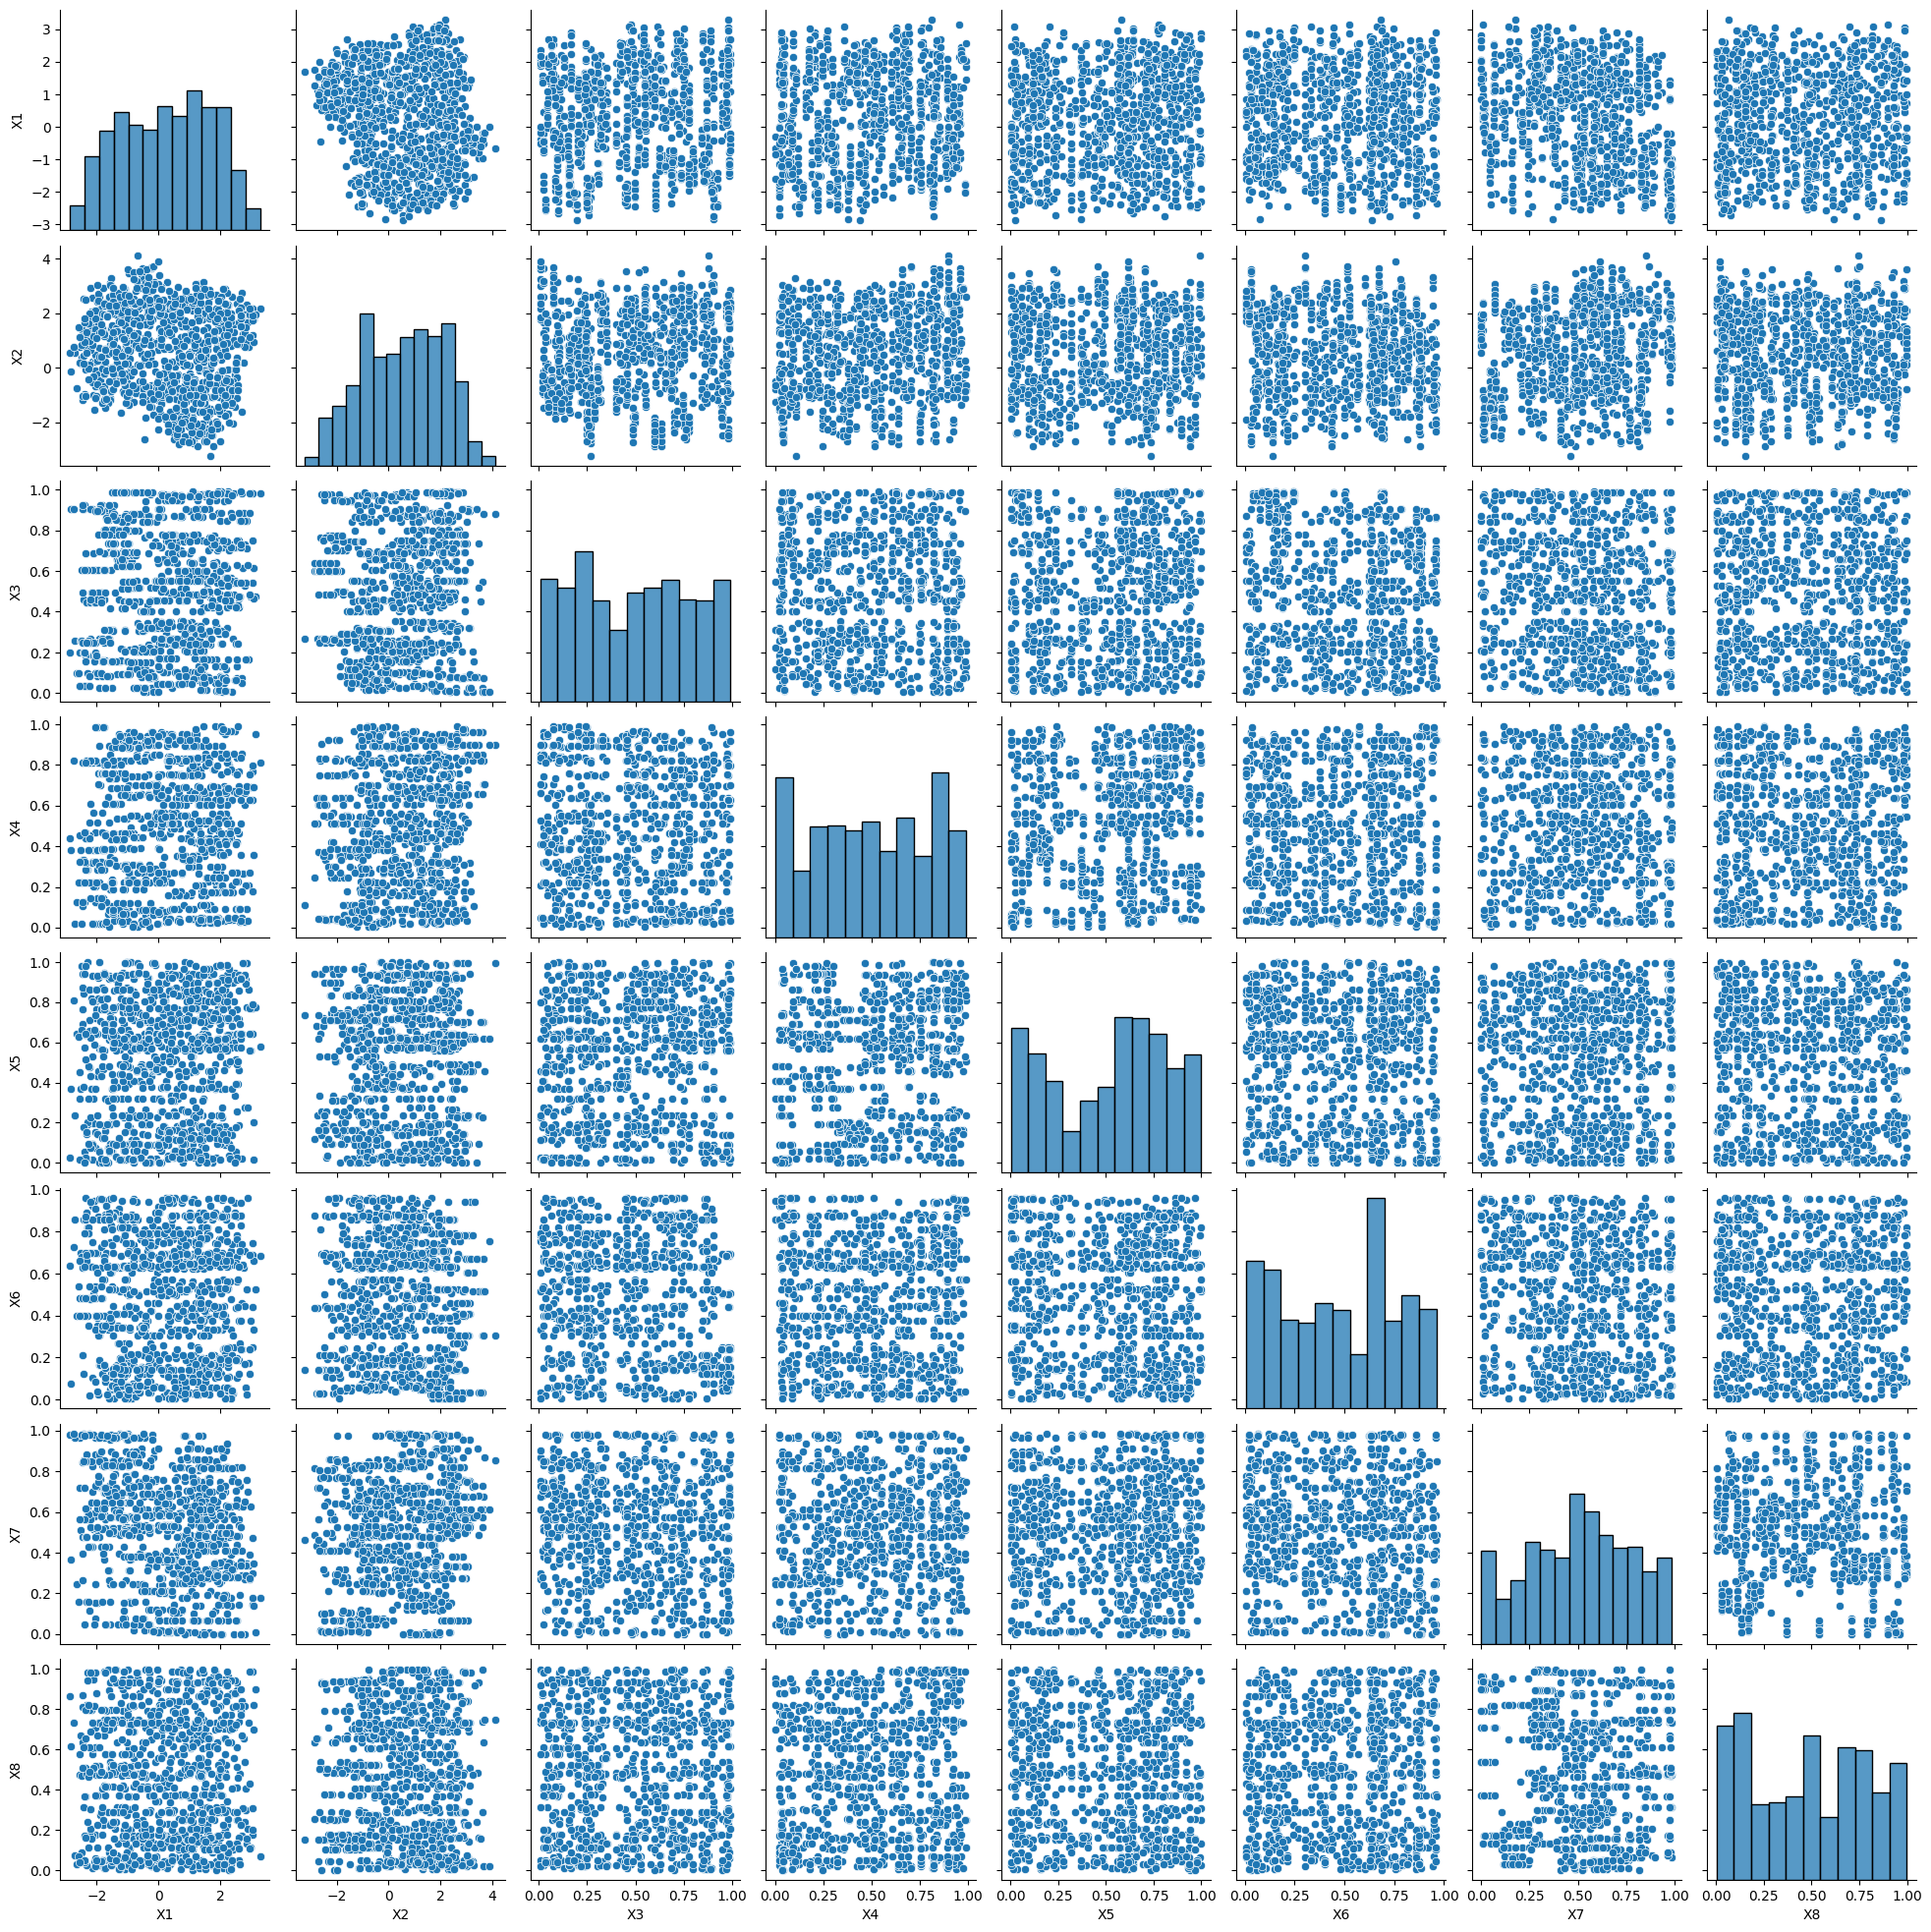

In [31]:
sns.pairplot(df)

## Correlation Matrix
Examining the correlation matrix, the most 'extreme' value I see is -0.27 between X7 and X1, which indicates a weak inverse relationship between the two. Beyond that, none of the features have any significant correlation. It stands to reason this dataset was generated programmatically (hence the generic feature names) so the lack of significant correlation makes sense.

In [36]:
feats = df[[c for c in df.columns if c != "Y"]]
correlation_matrix = feats.corr()
correlation_matrix

,X1,X2,X3,X4,X5,X6,X7,X8
X1,1.000000,-0.162925,0.053404,0.048797,0.064429,-0.030689,-0.271790,-0.004266
X2,-0.162925,1.000000,0.063820,0.176044,0.037858,-0.059990,0.178142,-0.020490
X3,0.053404,0.063820,1.000000,-0.007330,0.028529,-0.074335,-0.107514,-0.013038
X4,0.048797,0.176044,-0.007330,1.000000,0.160035,0.028746,0.026834,0.083458
X5,0.064429,0.037858,0.028529,0.160035,1.000000,-0.054253,0.022389,-0.073225
X6,-0.030689,-0.059990,-0.074335,0.028746,-0.054253,1.000000,-0.129064,0.021826
X7,-0.271790,0.178142,-0.107514,0.026834,0.022389,-0.129064,1.000000,-0.016308
X8,-0.004266,-0.020490,-0.013038,0.083458,-0.073225,0.021826,-0.016308,1.000000


## Summary Statistics
These aren't meant to mean anything on their own, but I'll run some EDA to see if there are outliers. Per the previous assumption (re:programmatically generated data) I don't expect there to be any significant outliers, but it's still worth checking and good practice

In [ ]:
summ_stats = pd.DataFrame(df.describe())
summ_stats

,X1,X2,X3,X4,X5,X6,X7,X8
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.254773,0.536335,0.494275,0.498409,0.515783,0.475717,0.513388,0.478012
std,1.466310,1.562186,0.293422,0.291705,0.300921,0.286278,0.265505,0.303457
min,-2.870362,-3.224785,0.008168,0.002185,0.000691,0.005480,0.000388,0.002317
25%,-0.988195,-0.753827,0.241284,0.241353,0.224492,0.191123,0.314070,0.176609
50%,0.328549,0.648445,0.495069,0.510937,0.579878,0.499447,0.524360,0.479805
75%,1.466949,1.875265,0.737394,0.757189,0.771056,0.697500,0.719687,0.733842
max,3.289581,4.123355,0.992868,0.988585,0.998897,0.961488,0.985987,0.999016


### EDA
I'll be examining mean and std, as those are the two most significant features to me (whether any features are significantly higher/lower or more/less volatile than others)

Findings:
I notice X1 has a significantly lower mean than the other 7 features, and both X1 and X2 have SIGNIFICANTLY higher standard deviations than the rest of the features. The high means indicate benefit from some sort of range standardization (MinMaxScaler, etc.). The significantly differing standard deviations indicate potential benefit from StandardScaler or RobustScaler, so perhaps an algorithm-based scaler/pipeline system would be better. For algorithms like SVM and Logistic Regression, StandardScaler could be the best choice, whereas with KNN (where it's purely distance), MinMaxScaler might address the more pressing differences in mean.

In [52]:
summ_stats_transposed = summ_stats.T # so that I can make a histogram of the summary stats
summ_stats_transposed["feature"] = summ_stats_transposed.index # so that I have the index to plot
summ_stats_transposed

,count,mean,std,min,25%,50%,75%,max,feature
X1,1000.0,0.254773,1.466310,-2.870362,-0.988195,0.328549,1.466949,3.289581,X1
X2,1000.0,0.536335,1.562186,-3.224785,-0.753827,0.648445,1.875265,4.123355,X2
X3,1000.0,0.494275,0.293422,0.008168,0.241284,0.495069,0.737394,0.992868,X3
X4,1000.0,0.498409,0.291705,0.002185,0.241353,0.510937,0.757189,0.988585,X4
X5,1000.0,0.515783,0.300921,0.000691,0.224492,0.579878,0.771056,0.998897,X5
X6,1000.0,0.475717,0.286278,0.005480,0.191123,0.499447,0.697500,0.961488,X6
X7,1000.0,0.513388,0.265505,0.000388,0.314070,0.524360,0.719687,0.985987,X7
X8,1000.0,0.478012,0.303457,0.002317,0.176609,0.479805,0.733842,0.999016,X8


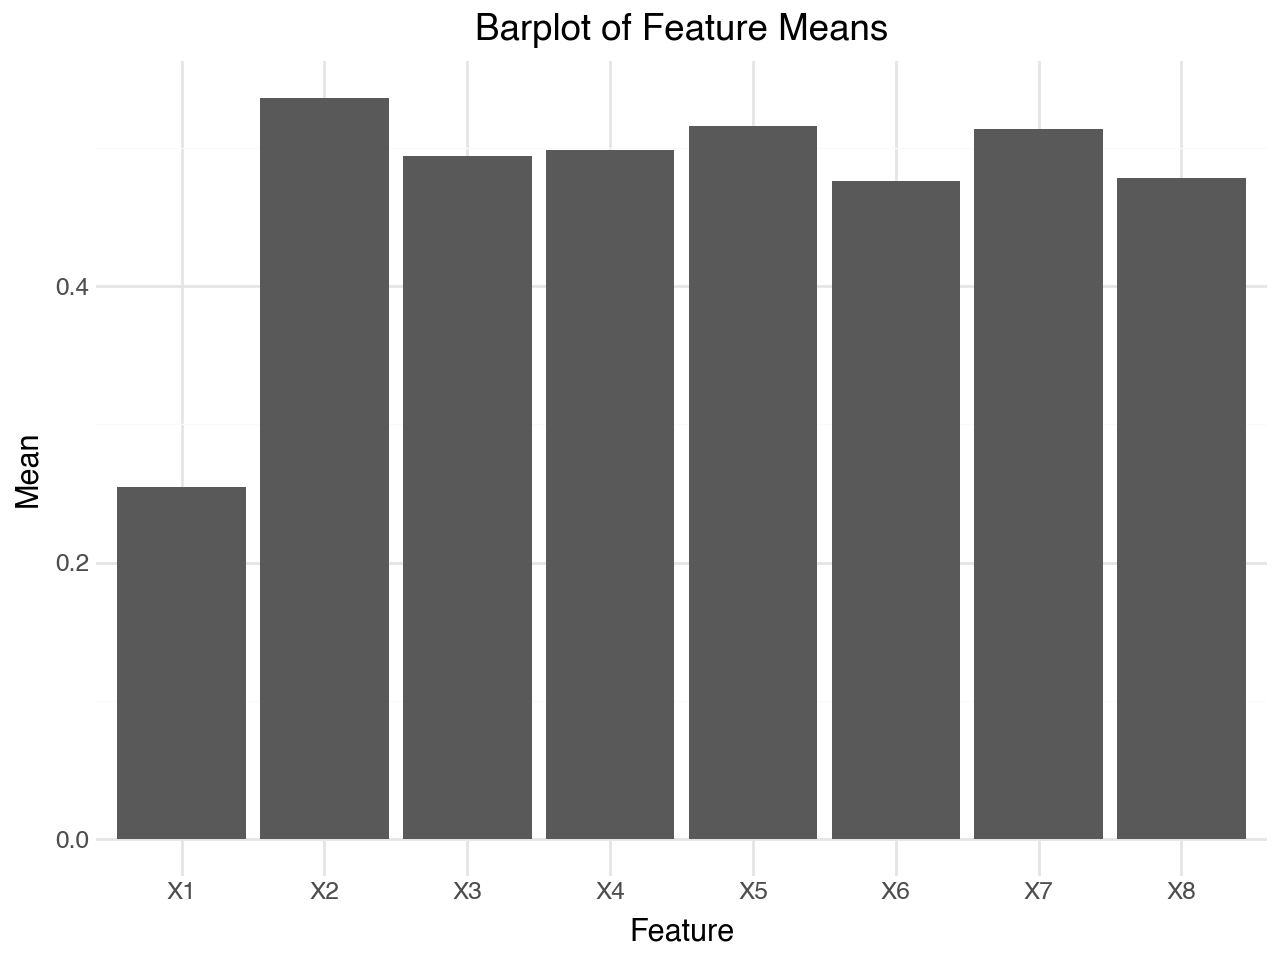

In [ ]:
# Barplot of Feature Means
(ggplot(summ_stats_transposed, aes(x="feature", y="mean")) + 
       geom_bar(stat="identity") +
       labs(title="Barplot of Feature Means", x="Feature", y="Mean") +
       theme_minimal()
)

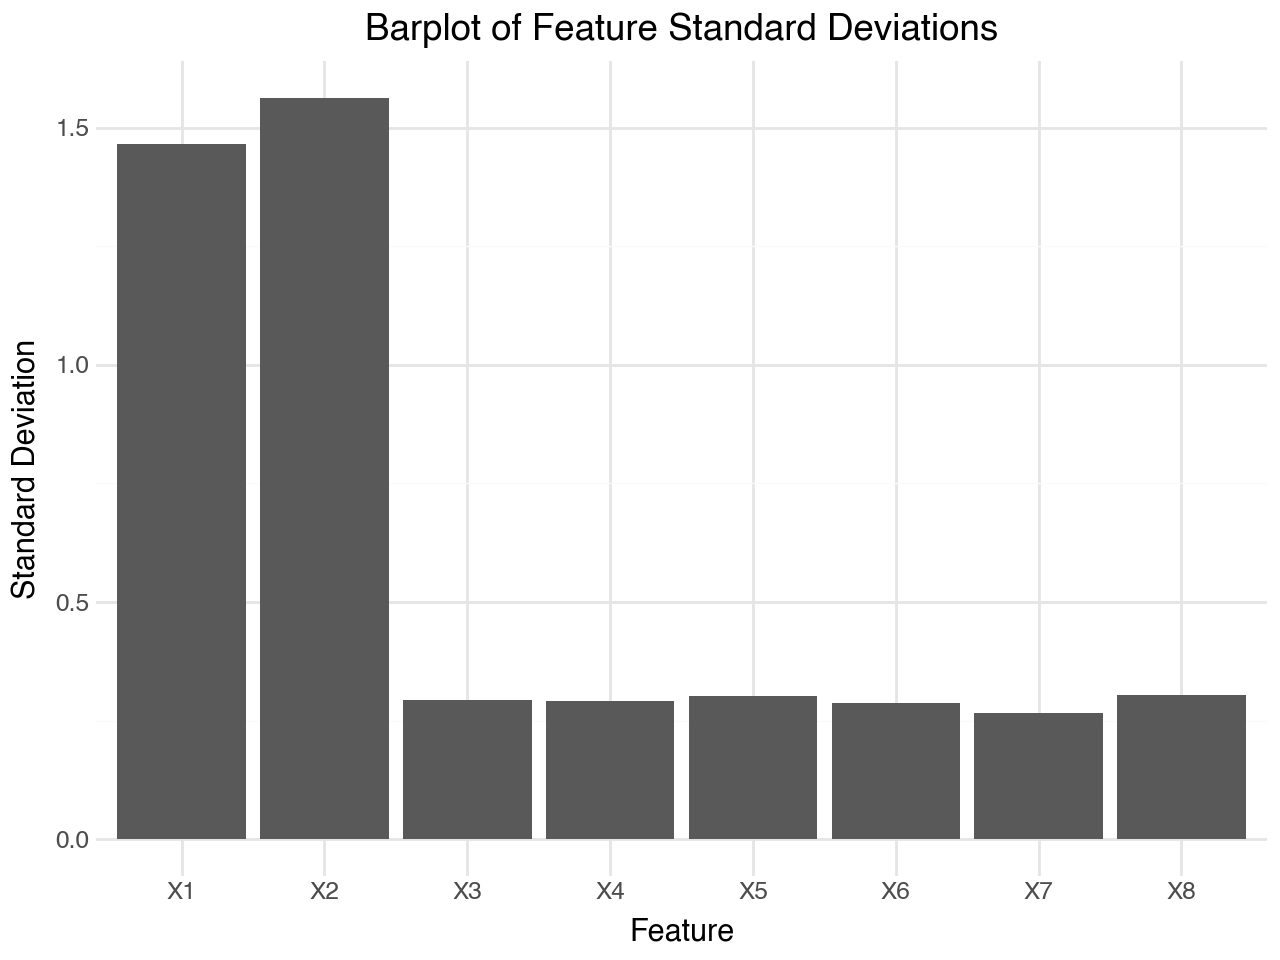

In [ ]:
# Barplot of Feature Standard Deviations
(ggplot(summ_stats_transposed, aes(x="feature", y="std")) + 
       geom_bar(stat="identity") +
       labs(title="Barplot of Feature Standard Deviations", x="Feature", y="Standard Deviation") +
       theme_minimal()
)

# SVM GridSearchCV

In [102]:
pipe = Pipeline([
    ('scaler',StandardScaler()), 
    ('svm',SVC()) 
])

param_grid = {
    'svm__C': [0.001, 0.01, 1, 5, 25, 50],
    'svm__gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5],
    'svm__kernel': ['rbf', 'linear']
}

grid = GridSearchCV(pipe,param_grid,cv=5)
grid.fit(X_train,y_train)

svm_best = grid.best_estimator_
print(f"Best C: {grid.best_params_['svm__C']}")
print(f"Best Gamma: {grid.best_params_['svm__gamma']}")
print(f"Best Kernel: {grid.best_params_['svm__kernel']}")

Best C: 1
Best Gamma: 2
Best Kernel: rbf


In [14]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

print("Train Accuracy:",accuracy_score(y_train,y_train_pred))
print("Test Accuracy:",accuracy_score(y_test,y_test_pred))

matrix = confusion_matrix(y_test,y_test_pred)
print("\nConfusion Matrix:\n",matrix)


y_test_pred = grid.decision_function(X_test)
roc_auc = roc_auc_score(y_test,y_test_pred)
print("\nTest ROC AUC:",roc_auc)

Train Accuracy: 0.79625
Test Accuracy: 0.785

Confusion Matrix:
 [[58 23]
 [20 99]]

Test ROC AUC: 0.8820417055711173


# Logistic Regression

In [71]:
features = ["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8"] # apparently makecolumntransformer doesn't like dataframes? So I need to redefine features. I like the previous way better though
pre = make_column_transformer((StandardScaler(), features),
                              remainder = "passthrough")
lr = LogisticRegression()

pipe = Pipeline([("pre", pre), ("model", lr)])

pipe.fit(X_train, y_train)


y_pred_train = pipe.predict(X_train) 
y_pred_test = pipe.predict(X_test)

y_pred_train_prob = pipe.predict_proba(X_train)[:,1] 
y_pred_test_prob = pipe.predict_proba(X_test)[:,1] 

print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob)) 

print("\n") # just for aesthetics :)

print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

Train Acc       :  0.75
Train ROC AUC   :  0.8349284158107686


Test Acc        :  0.795
Test ROC AUC    :  0.8741570702355016


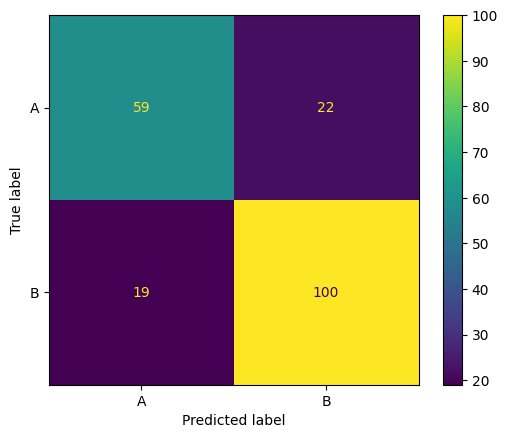

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test) # just a little something from 392...

# KNN GridSearchCV

{'memory': None, 'steps': [('pre', ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
                                  'X8'])])), ('model', KNeighborsClassifier())], 'transform_input': None, 'verbose': False, 'pre': ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7',
                                  'X8'])]), 'model': KNeighborsClassifier(), 'pre__force_int_remainder_cols': True, 'pre__n_jobs': None, 'pre__remainder': 'passthrough', 'pre__sparse_threshold': 0.3, 'pre__transformer_weights': None, 'pre__transformers': [('minmaxscaler', MinMaxScaler(), ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])], 'pre__verbose': False, 'pre__verbose_feature_names_out': True, 'pre__minmaxscaler': MinMaxScaler(), 'pre__minmaxscaler__clip'

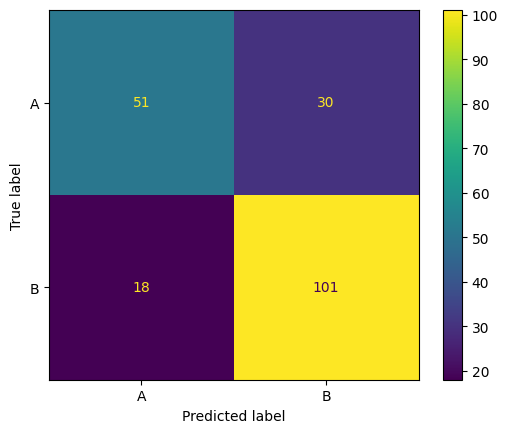

In [58]:
knn = KNeighborsClassifier()

z = make_column_transformer((MinMaxScaler(), features),
                            remainder = "passthrough")

pipe = Pipeline([("pre", z), ("model", knn)])

ks = {"model__n_neighbors": [1,2,3,4,5,6,7,8,9,10,15,20,25,30]}

print(pipe.get_params()) 

grid = GridSearchCV(pipe, ks, scoring = "accuracy", cv = 5, refit = True)

grid.fit(X_train, y_train)

print("GridSearchCV chose: ", grid.best_estimator_.get_params()["model__n_neighbors"])

y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)

y_pred_train_prob = grid.predict_proba(X_train)[:,1]
y_pred_test_prob = grid.predict_proba(X_test)[:,1]

print("Train Acc       : ", accuracy_score(y_train, y_pred_train))
print("Train ROC AUC   : ", roc_auc_score(y_train, y_pred_train_prob))

print("\n") # just for aesthetics :)

print("Test Acc        : ", accuracy_score(y_test, y_pred_test))
print("Test ROC AUC    : ", roc_auc_score(y_test, y_pred_test_prob))

ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test) # just a little something from 392...

# PCA  

## Run PCA On Dataset & Create Df of PC's

In [ ]:
feats_pca = df.drop(columns=["Y"])

pipe_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA())
])

# fit
pipe_pca.fit(feats_pca)

df_PCs = pd.DataFrame(pipe_pca.transform(feats_pca))
df_PCs.columns = ["PC" + str(i+1) for i in range(len(features))] # copied from 392... I think this should be in range (1,2) to only get the first 2 and not need to drop later on but oh well
df_PCs["Y"] = df["Y"] # adding back the target variable
df_PCs.drop(columns=["PC3","PC4","PC5","PC6","PC7","PC8"], inplace=True) # dropping all but first 2 PCs
df_PCs.head()

,PC1,PC2,Y
0,-0.392531,-2.164888,B
1,-2.340664,-1.641434,B
2,0.248848,-0.861021,B
3,0.294218,1.013903,A
4,-0.154532,0.308218,B


## Start of the pipeline

In [86]:
Y = df_PCs["Y"]
features = df_PCs[[c for c in df_PCs.columns if c != "Y"]]
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2, random_state=3619)
# features


## Actual Pipeline

In [91]:
pca_pipe = Pipeline([
    ('scaler',StandardScaler()), 
    ('svm',SVC()) 
])

param_grid2 = {
    'svm__C': [0.001, 0.01, 1, 5, 25, 50],
    'svm__gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5],
    'svm__kernel': ['rbf', 'linear']
}

grid2 = GridSearchCV(pca_pipe,param_grid2,cv=5)
grid2.fit(X_train,y_train)

svm_best = grid2.best_estimator_
print(f"Best C: {grid2.best_params_['svm__C']}")
print(f"Best Gamma: {grid2.best_params_['svm__gamma']}")
print(f"Best Kernel: {grid2.best_params_['svm__kernel']}")

Best C: 1
Best Gamma: 2
Best Kernel: rbf


## Model Prediction on 2 PCs

I assumed we were supposed to use the best model. Technically Logistic Regression peaked higher but SVM performed nearly as well and logistic regression had a big difference between training and testing sets, which makes me think it might be slightly unreliable, so I'll stick with SVM

In [98]:
y_train_pred = grid2.predict(X_train)
y_test_pred = grid2.predict(X_test)

print("Train Accuracy:",accuracy_score(y_train,y_train_pred))
print("Test Accuracy:",accuracy_score(y_test,y_test_pred))

matrix = confusion_matrix(y_test,y_test_pred)
print("\nConfusion Matrix:\n",matrix)


y_test_pred_decisions = grid2.decision_function(X_test)
roc_auc = roc_auc_score(y_test,y_test_pred_decisions)
print("\nTest ROC AUC:",roc_auc)

Train Accuracy: 0.7325
Test Accuracy: 0.73

Confusion Matrix:
 [[51 30]
 [24 95]]

Test ROC AUC: 0.7771553065670712


## Constructing Dataframe of PC's, Targeted, and Actual Classes for Plotting

In [99]:
predictions = pd.DataFrame({
    "PC1" : X_test.iloc[:,0],
    "PC2" : X_test.iloc[:,1],
    "Actual" : y_test,
    "Predicted" : y_test_pred
})
predictions.info() # checking we have a populated dataframe (200 expected since 80/20 tts)

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 878 to 196
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PC1        200 non-null    float64
 1   PC2        200 non-null    float64
 2   Actual     200 non-null    object 
 3   Predicted  200 non-null    object 
dtypes: float64(2), object(2)
memory usage: 7.8+ KB


### Plotting Actual Classes

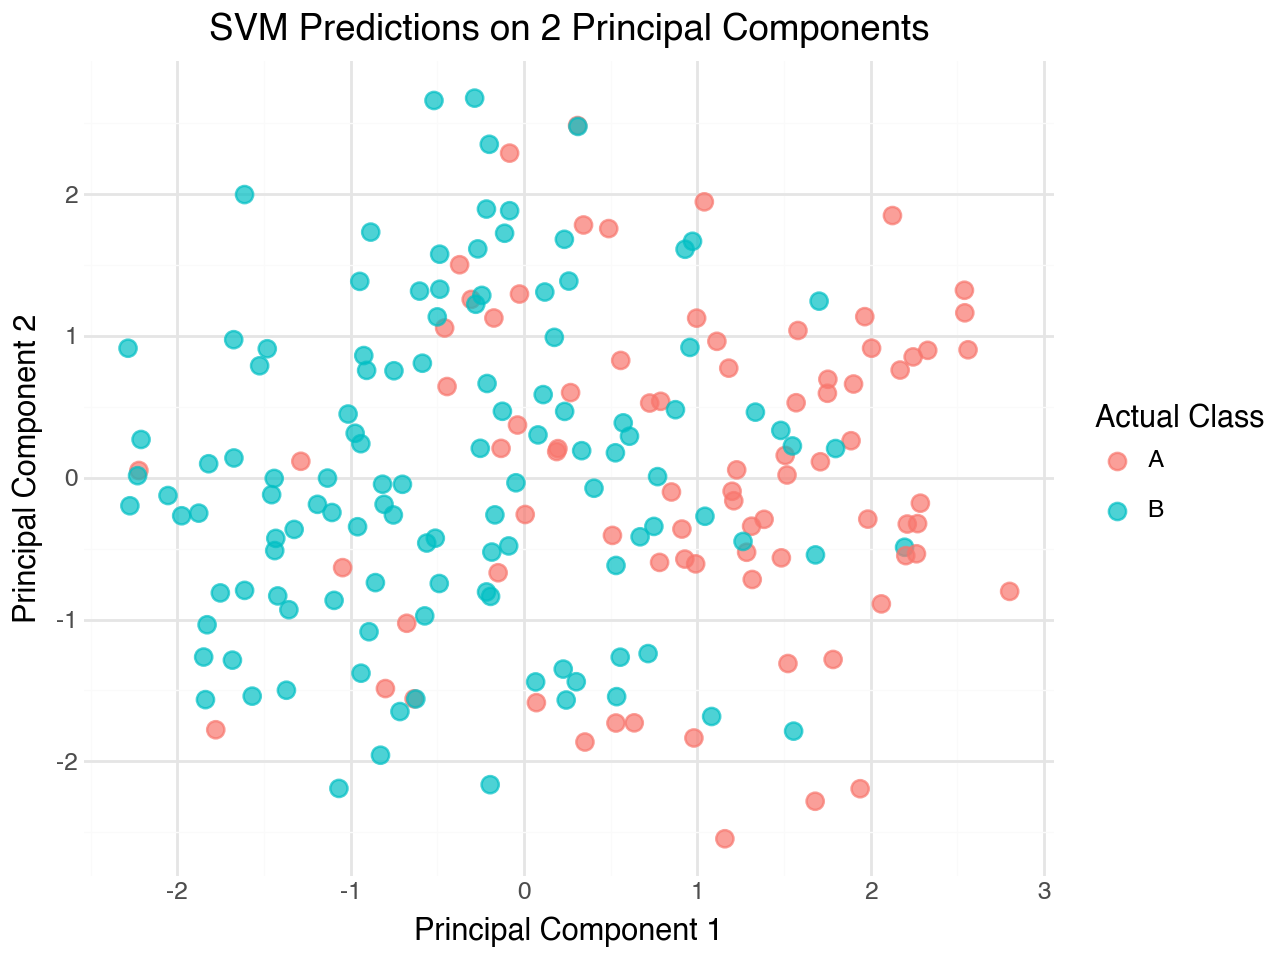

In [100]:
(ggplot(predictions, aes(x="PC1", y="PC2", color = "factor(Actual)")) +
    geom_point(size=3, alpha=0.7) +
    labs(title="SVM Predictions on 2 Principal Components", x="Principal Component 1", y="Principal Component 2", color="Actual Class") +
    theme_minimal())

### Plotting Targeted Classes

This isn't a very "scientific" check, but we can tell that this plot is indeed the targeted one because we can almost imagine where the hyperplane (in this case a line) was drawn, with the support vectors and a vew violations on each side (in particular the 3 red points at the top middle of the plot)

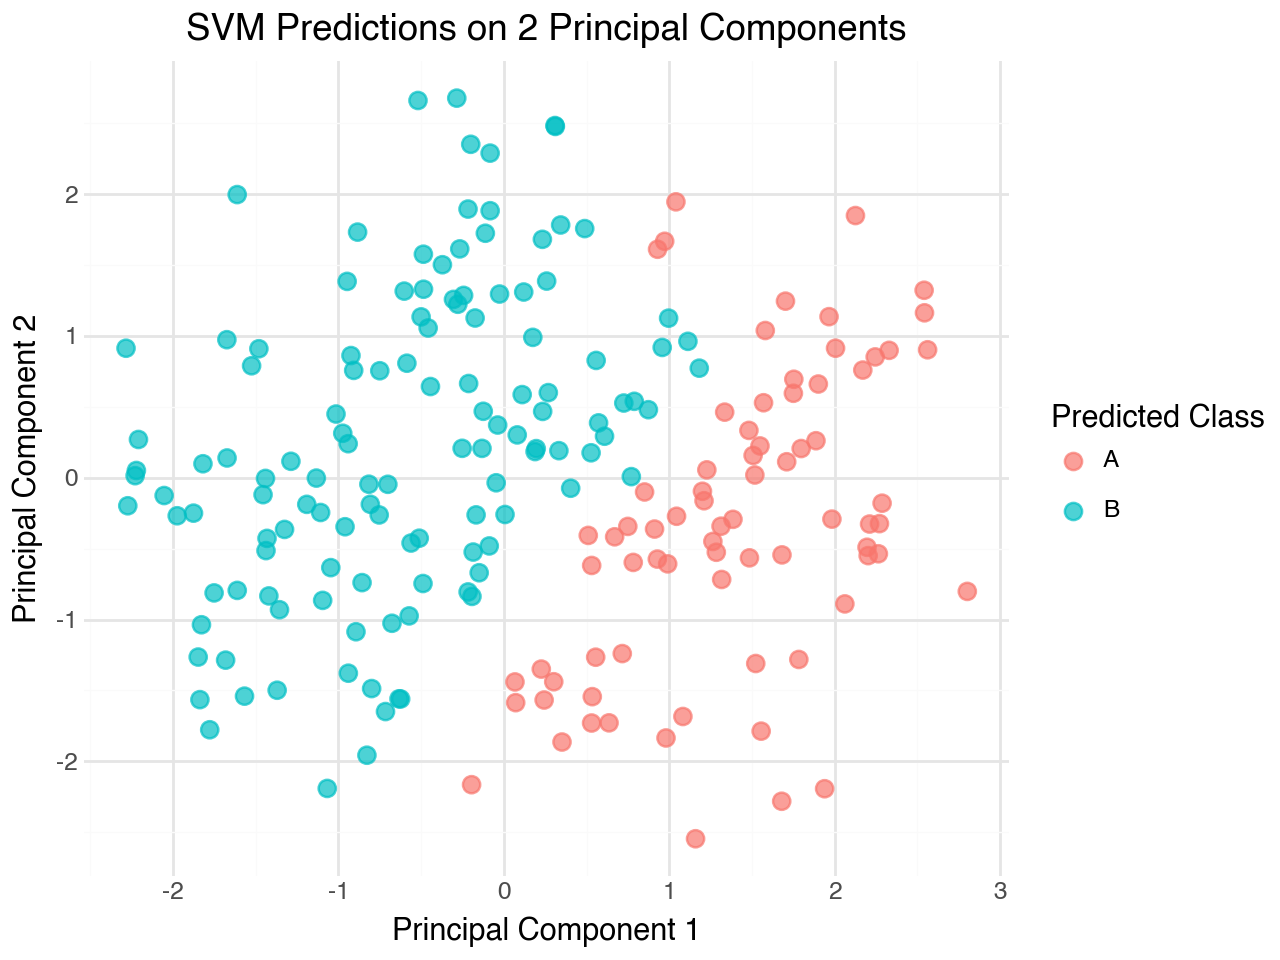

In [101]:
(ggplot(predictions, aes(x="PC1", y="PC2", color = "factor(Predicted)")) +
    geom_point(size=3, alpha=0.7) +
    labs(title="SVM Predictions on 2 Principal Components", x="Principal Component 1", y="Principal Component 2", color="Predicted Class") +
    theme_minimal())